# Correlation analysis between calcium signal of chx10+ hindbrain neurons and tail angle in ZF larva during OMR stimulation

***7 dpf larva - Tg(chx10:Gal4;UAS:GCaMP6s) - #540 - ref fish:200813_F1***

***2P microscope acquisition of the calcium signal***

In [1]:
import os, pickle, base64
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from scipy.stats import zscore
from matplotlib import cm
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from PIL import Image, ImageSequence
# the following doesn't work on Jupytr notebook, why ?
# from utils.correlation_tools import *

### Initialization

In [24]:
output_path = '/network/lustre/iss01/wyart/analyses/2pehaviour/ML_pipeline_output/'
suite2p_path = '/network/lustre/iss01/wyart/analyses/2pehaviour/suite2p_output/'
tif_path = '/home/mathilde.lapoix/Documents/RSN_project/Data/2P/'
fishlabel = '200813_F1'
depth = '190um'
nFrames = 454+454+454
frame_rate_2p = 4.4

--------------------------------------
#### Need to define all functions here since for some reason I can't import libraries from module.


In [25]:
def calcium_kernel(tau):
    """Builds calcium transient trace, based on a tau value defined by user.
    
    :param tau: The tau value you want to give to your exponential decay
    
    :return: exponential function with tau decay
    """
    return lambda x: np.exp(-x/(tau/np.log(2)))


def convolve_regressors(regressor, kernel):
    """ Convolves the regressor with a kernel function
    :param regressor: the regressor, or regressor matrix
    :param kernel:
    :return: the convolved kernel
    """
    return np.convolve(regressor, kernel)[0:len(regressor)]


def matplot2plotly_cmap(cmap_type, nsamp=200):
    """ Builds a colorscale for matplotlib. Exact same function as found on the stytra paper GitHub.
    """
    x = (np.linspace(0, 1, nsamp))
    color_mat = (cm.get_cmap(cmap_type)(x)*255).astype(np.uint8)[:,:3]
    return [[v, "rgb{}".format(tuple(c))] for v, c in zip(x, color_mat)]


def load_suite2p_outputs(file_name, input_path):
    """Load every output that the suite2p gives you
    Arguments given are fishlabel, real_trial_num and folder_path.
    If folder_path is not given, automatically check for the data path in the summary csv file.
    You can change the path to the summary csv file here in the function.
    If folder_path is given;
    Returns F, Fneu, spks, stat, ops, iscell"""
    if not os.path.exists(input_path):
        raise FileNotFoundError('Path to your folder is not valid.')
    try:
            F = np.load(input_path + file_name + '/suite2p/plane0' + '/F.npy', allow_pickle=True)
            Fneu = np.load(input_path + file_name + '/suite2p/plane0' + '/Fneu.npy', allow_pickle=True)
            spks = np.load(input_path + file_name + '/suite2p/plane0' + '/spks.npy', allow_pickle=True)
            stat = np.load(input_path + file_name + '/suite2p/plane0' + '/stat.npy', allow_pickle=True)
            ops = np.load(input_path + file_name + '/suite2p/plane0' + '/ops.npy', allow_pickle=True)
            ops = ops.item()
            iscell = np.load(input_path + file_name + '/suite2p/plane0' + '/iscell.npy', allow_pickle=True)
    except FileNotFoundError:
        F = np.load(input_path + file_name + '/F.npy', allow_pickle=True)
        Fneu = np.load(input_path + file_name + '/Fneu.npy', allow_pickle=True)
        spks = np.load(input_path + file_name + '/spks.npy', allow_pickle=True)
        stat = np.load(input_path + file_name + '/stat.npy', allow_pickle=True)
        ops = np.load(input_path + file_name + '/ops.npy', allow_pickle=True)
        ops = ops.item()
        iscell = np.load(input_path + file_name + '/iscell.npy', allow_pickle=True)
    return F, Fneu, spks, stat, ops, iscell


def nandot(X, Y):
    """Sum two arrays, but taking the NaN into account (sum functions does not naturally)"""
    return np.nansum(X*Y)


def pearson_coef_pixel(pixel, regressor):
    """ Calculates the pearson coefficient value between two signal.
    
    :param pixel: numpy array of the pixel intensity in time
    :param regressor: numpy array of whatever signal you want to correlate your pixel intensity with. Here, tail angle trace.
    
    :return: pearson correlation coefficient between the 2 signals.
    """
    X = pixel_traces[pixel]
    Y = regressor
    # if regressor is shorter, reduce the size of the pixel trace. Could have filled with 0 the remaining, it depends on how sure you are that your regressor is well built.
    # Thing is the pixel value would not really be 0, you would need to take something as the baseline value for this pixel, and add noise.
    if X.shape != Y.shape:
        Y_bis = np.zeros(X.shape)
        Y_bis[0:len(Y)] = Y
        Y = Y_bis
    numerator = nandot(X, Y) - X.shape[0] * np.nanmean(X) * np.nanmean(Y)
    denominator = (X.shape[0] - 1) * np.nanstd(X) * np.nanstd(Y)
    pearson_corr = numerator/denominator
    return pearson_corr

In [26]:
%matplotlib inline

#### Loading tif file of the registered tif.

In [29]:
# loading the tif image
im = Image.open(tif_path+fishlabel+'/concatenated_stack_'+depth+'.tif')

# converting the tiff image in array
imarray = np.array(im)

# the tiff array will be in 3D: 2D of number of pixels, and the third D is the time.
# 
tiff_array = np.zeros((imarray.shape[0], imarray.shape[1], nFrames))

# get each frame of the tif file to be concatenated to the array
for i, frame in enumerate(ImageSequence.Iterator(im)):
    tiff_array[:,:,i] = frame

In [30]:
# loading suite2P outputs
# F, Fneu, spks, stat, ops, iscell = load_suite2p_outputs(depth, suite2p_path+'/'+fishlabel+'/')

# define condition of movement
# condition_movement = ops['xoff'] < -3
# bad_frames = np.where(condition_movement)
# len(bad_frames[0])

In [31]:
# remove frames with movement
# tiff_array[:,:, bad_frames] = np.nan

# calculate the zscore of each trace, and reshape the array to lines as pixel number, and cols as time
pixel_traces = zscore(tiff_array.reshape((-1, tiff_array.shape[2])))

Load TA array, already rescale to match the frame rate from the 2P.
Early stages of analysis: no extraction from ZZ output, so no idea when bout was one the left or right. 
 Will just delete the angle on one side or the other to build side regressors.

Text(0.5, 1.0, 'TA right')

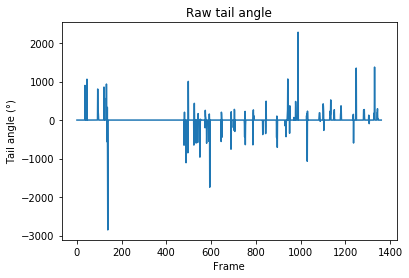

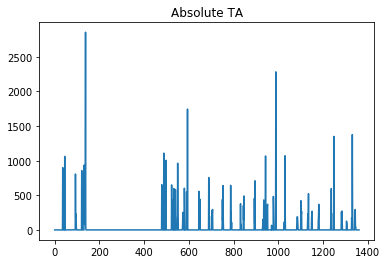

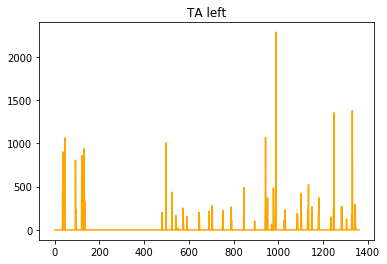

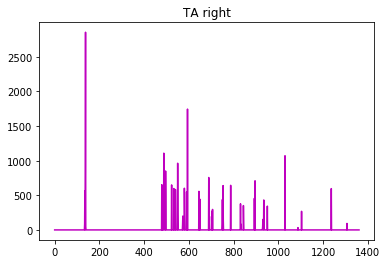

In [32]:
TA = np.load(output_path+'np_array/'+fishlabel+'/'+depth+'/overall_ta.npy')

plt.figure()
plt.plot(TA)
plt.ylabel('Tail angle (°)')
plt.xlabel('Frame')
plt.title('Raw tail angle')

# need to convert your TA in absolute value in order to calculate the correlation with the calcium signal.
abs_ta = abs(TA)
ta_left = TA.copy()
ta_right = TA.copy()
ta_left[ta_left < 0] = 0
ta_right[ta_right > 0] = 0
ta_right = abs(ta_right)
plt.figure()
plt.plot(abs_ta)
plt.title('Absolute TA')
plt.figure()
plt.plot(ta_left, 'orange')
plt.title('TA left')
plt.figure()
plt.plot(ta_right, 'm')
plt.title('TA right')

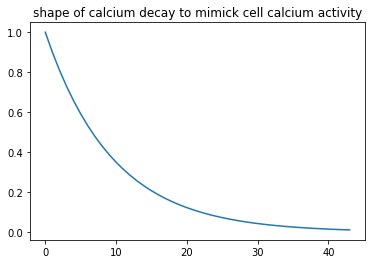

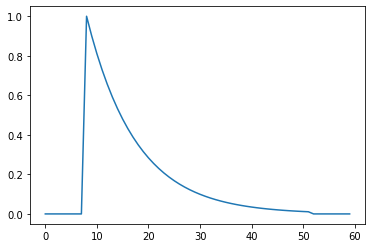

In [33]:
# ker is the shape of the calcium transient: it's the negative exponential with b = 1/tau, from 0 to 10sec
# and is shaped with time steps of 1/frame_rate_2p
ker = calcium_kernel(1.5)(np.arange(0,10,1/frame_rate_2p))
ker_zeros = np.zeros((int(2*frame_rate_2p)))
ker2 = np.concatenate((ker_zeros, ker, ker_zeros))
plt.plot(ker)
plt.title('shape of calcium decay to mimick cell calcium activity')
plt.figure()
plt.plot(ker2)

In [34]:
# Then the final step is to convolve these regressors with the kernel shape we built (the calcium decay shape)

# first we convolve (we get really high values since convolving is a kind of multiplication)
# need to flatten the array I don't really remember why but it doesn't work otherwise
convolved = convolve_regressors(abs_ta.flatten(), ker)
# then we calculate the zscore (a way to normalize the value to the mean and the std of the regressor)
final_all_reg = zscore(convolved)
final_left_reg = zscore(convolve_regressors(ta_left.flatten(), ker))
final_right_reg = zscore(convolve_regressors(ta_right.flatten(), ker))

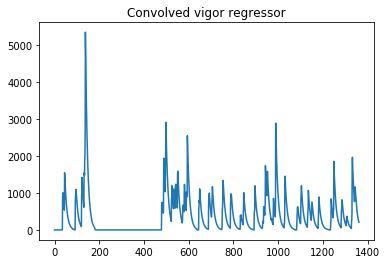

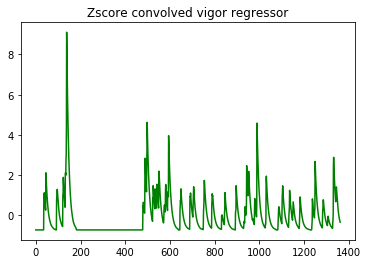

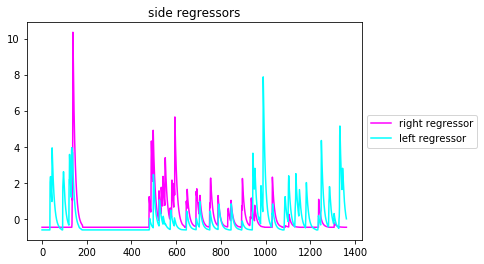

In [35]:
plt.figure()
plt.title('Convolved vigor regressor')
plt.plot(convolved)
plt.figure()
plt.title('Zscore convolved vigor regressor')
plt.plot(final_all_reg, color='green')
plt.figure()
plt.title('side regressors')
plt.plot(final_right_reg, color='magenta', label='right regressor')
plt.plot(final_left_reg, color='cyan', label='left regressor')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fancybox=True)

In [36]:
# calculate this pearson coef for each pixel by applying parallelized function
pixels = range(pixel_traces.shape[0])
cmap_left_pixel = pd.Series(pixels).apply(pearson_coef_pixel, args=(final_left_reg,))
cmap_right_pixel = pd.Series(pixels).apply(pearson_coef_pixel, args=(final_right_reg,))
cmap_vigor_pixel = pd.Series(pixels).apply(pearson_coef_pixel, args=(final_all_reg,))

In [37]:
# you got a long format pd.Series of this value, now you want to give it back the shape of the image
# reshape from long format to height (dimension 0) x width (dimension 1) format
cmap_lp = np.array(cmap_left_pixel).reshape(*tiff_array.shape[0:2])
cmap_rp = np.array(cmap_right_pixel).reshape(*tiff_array.shape[0:2])
cmap_vp = np.array(cmap_vigor_pixel).reshape(*tiff_array.shape[0:2])

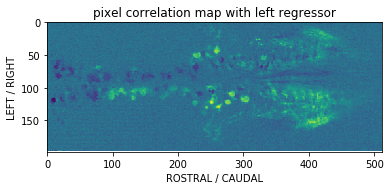

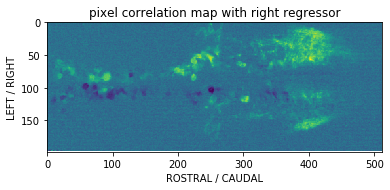

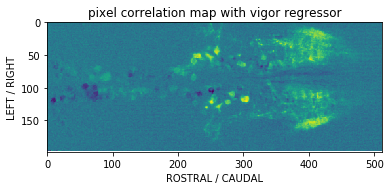

In [38]:
# quick view
plt.imshow(cmap_lp)
plt.title('pixel correlation map with left regressor')
plt.ylabel('LEFT / RIGHT')
plt.xlabel('ROSTRAL / CAUDAL')
plt.xlim(0, imarray.shape[1])
plt.ylim(imarray.shape[0], 0)
plt.savefig(output_path+'fig/'+fishlabel+'/'+depth+'/pixel_cmap_left_reg.png')
plt.figure()
plt.imshow(cmap_rp)
plt.title('pixel correlation map with right regressor')
plt.ylabel('LEFT / RIGHT')
plt.xlabel('ROSTRAL / CAUDAL')
plt.xlim(0, imarray.shape[1])
plt.ylim(imarray.shape[0], 0)
plt.savefig(output_path+'fig/'+fishlabel+'/'+depth+'/pixel_cmap_right_reg.png')
plt.figure()
plt.imshow(cmap_vp)
plt.title('pixel correlation map with vigor regressor')
plt.ylabel('LEFT / RIGHT')
plt.xlabel('ROSTRAL / CAUDAL')
plt.xlim(0, imarray.shape[1])
plt.ylim(imarray.shape[0], 0)
plt.savefig(output_path+'fig/'+fishlabel+'/'+depth+'/pixel_cmap_vigor_reg.png')
